To run: Run all cells from the top to the bottom

### Import modules

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw

from general_functions import SENT_BEG, SENT_END
from gensim.models import Word2Vec
from scipy.stats import linregress

In [2]:
# mini_G = nx.read_gml('./Graphs/mini_graph.gml')
vocab_G = nx.read_gml('./Graphs/corpus_vocab.gml')
len(vocab_G)

11553

### Degree distribution

In [3]:
def degree_distro(G: nx.DiGraph, name) -> (float, float):
    """Get the degree exponent and plot the degree distribution of a network
    Parameters:
        G (nx.DiGraph): a directed network
        name (str): the name of the network
    Returns:
        float: the in-degree exponent
        float: the out-dgree exponent"""
    
    in_deg = np.array([i for i in dict(vocab_G.in_degree()).values() if i > 0])
    out_deg = np.array([i for i in dict(vocab_G.out_degree()).values() if i > 0])
    
    k_min, k_max = min(min(in_deg), min(out_deg)), max(max(in_deg), max(out_deg))
    
    # get log bins and density
    bin_edges = np.logspace(np.log10(k_min), np.log10(k_max), num = 25)
    in_density, _ = np.histogram(in_deg, bins = bin_edges, density = True)
    out_density, _ = np.histogram(out_deg, bins = bin_edges, density = True)
    
    # calculate degree exponent
    in_res = powerlaw.Fit(in_deg, discrete = True)
    print('In-degree gamma:', in_res.power_law.alpha)
    out_res = powerlaw.Fit(out_deg, discrete = True)
    print('Out-degree gamma:', out_res.power_law.alpha)
    
    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[: -1] + log_be[1 :]) / 2)
    
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.loglog(x, in_density, marker = 'o', ls = 'none', color = '#1c39bb', label = 'In-degree')
    plt.loglog(x, out_density, marker = '^', ls = 'none', color = '#ff8b00', label = 'Out-degree')
    plt.title('{} Network Degree Distribution'.format(name))
    plt.xlabel('Degree k')
    plt.ylabel('Density p(k)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Vis/Network/degree_distro')
    plt.show()
    plt.close()
    
    return in_res.power_law.alpha, out_res.power_law.alpha

Calculating best minimal value for power law fit
In-degree gamma: 2.116121145212781
Calculating best minimal value for power law fit
Out-degree gamma: 2.1924391900543463


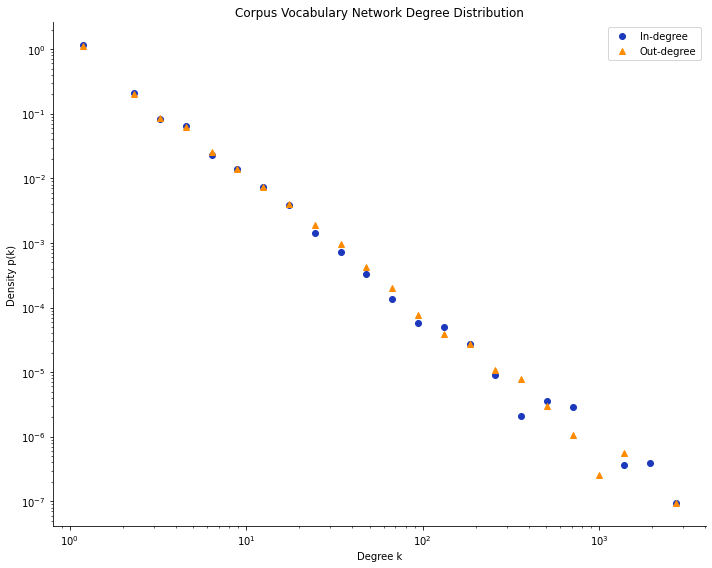

In [4]:
in_deg_exp, out_deg_exp = degree_distro(vocab_G, 'Corpus Vocabulary')

### Network Metrics

* In-degrees vs Out-degrees
* Term Frequencies vs In/Out-degrees
* HITS

In [5]:
def in_out_degrees(G: nx.DiGraph, in_deg: list, out_deg: list, name, threshold = 700) -> None:
    """Plot the in-degrees vs out-degrees of a directed network
    Parameters:
        G (nx.DiGraph): the network
        in_deg (list): the in-degrees
        out_deg (list): the out-degrees
        name (str): the name of the network
        threshold (int): the min degree for a point to be annotated (default: 700)
    Returns:
        None"""
    
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(in_deg, out_deg, alpha = 0.7, color = '#552583')
    
    for i in G.nodes:
        if G.in_degree(i) > threshold or G.out_degree(i) > threshold:
            plt.annotate(i, xy = (G.in_degree(i), G.out_degree(i)), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom', size = 10)
    
    plt.title('{}: In-degrees vs Out-degrees'.format(name))
    plt.xlabel('In-degree')
    plt.ylabel('Out-degree')
    plt.tight_layout()
    plt.savefig('./Vis/Network/in_v_out_degree_{}'.format(name))
    plt.show()
    plt.close()

In [6]:
def freq_v_degree(G: nx.DiGraph, freqs: dict, deg_type, name) -> None:
    """Plot the term frequencies vs degrees of a directed network
    Parameters:
        G (nx.DiGraph): the network
        freqs (dict): the frequencies of the nodes
        deg_type (str): the type of degree being plotted
        name (str): the name of the network
    Returns:
        None"""
    
    deg = None
    
    if deg_type == 'In':
        deg = np.array([G.in_degree(i) for i in freqs])
    else:
        deg = np.array([G.out_degree(i) for i in freqs])
        
    freqs_arr = np.array(list(freqs.values()))
    
    res = linregress(np.log10(freqs_arr), y = np.log10(deg))
    print('{}: Term Frequency vs {}-degrees'.format(name, deg_type))
    print('Predicted intercept:', 10 ** res.intercept)
    print('Predicted slope:', res.slope)
    
    pred = (res.slope * np.sort(np.log10(freqs_arr))) + res.intercept
        
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(np.log10(freqs_arr), np.log10(deg), alpha = 0.4, color = '#552583', label = 'Observed')
    plt.plot(np.log10(freqs_arr), pred, ls = '--', color = '#ff8b00', label = 'Predicted')
    plt.title('{}: Term Frequency vs {}-degrees'.format(name, deg_type))
    plt.xlabel('Log Term Frequency')
    plt.ylabel('Log {}-degree'.format(deg_type))
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Vis/Network/freq_v_{}_degree_{}'.format(deg_type, name))
    plt.show()
    plt.close()

#     fig = plt.figure(figsize = (10, 8))
#     plt.scatter(freqs_arr, deg, alpha = 0.4, color = '#552583', label = 'Observed')
#     plt.plot(freqs_arr, 10 ** pred, ls = '--', color = '#ff8b00', label = 'Predicted')
#     plt.title('{}: Term Frequency vs {}-degrees'.format(name, deg_type))
#     plt.xlabel('Term Frequency')
#     plt.ylabel('{}-degree'.format(deg_type))
#     plt.legend()
#     plt.show()
#     plt.close()

In [7]:
def hits(G: nx.DiGraph, name) -> None:
    """Run HITS for a directed network
    Parameters:
        G (nx.DiGraph): the network
        name (str):
    Returns:
        None"""

    hub_scores, auth_scores = nx.hits(G)
    
#     nx.set_node_attributes(G, hub_scores, 'hub_score')
#     nx.set_node_attributes(G, auth_scores, 'auth_score')
    
    in_deg = [G.in_degree(i) for i in hub_scores]
    out_deg = [G.out_degree(i) for i in auth_scores]
    
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(list(hub_scores.values()), in_deg, alpha = 0.4, color = '#552583')
    
    for i in hub_scores:
        if G.in_degree(i) > 500:
            plt.annotate(i, xy = (hub_scores[i], G.in_degree(i)), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom', size = 10)
            
    plt.title('Hub Scores vs In-degrees')
    plt.xlabel('Hub Score')
    plt.ylabel('In-degree')
    plt.tight_layout()
    plt.savefig('./Vis/Network/hubs_v_indegree_{}'.format(name))
    plt.show()
    plt.close()
    
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(list(auth_scores.values()), out_deg, alpha = 0.4, color = '#552583')

    for i in auth_scores:
        if G.out_degree(i) > 500:
            plt.annotate(i, xy = (auth_scores[i], G.out_degree(i)), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom', size = 10)
    
    plt.title('Authority Scores vs Out-degrees')
    plt.xlabel('Authority Score')
    plt.ylabel('Out-degree')
    plt.tight_layout()
    plt.savefig('./Vis/Network/auth_v_outdegree_{}'.format(name))
    plt.show()
    plt.close()

In [8]:
def plots_base(G: nx.DiGraph, name) -> None:
    """Plot various network properties
    Parameters:
        G (nx.DiGraph): the network
        name (str): the name of the network
    Returns:
        None"""
    
    in_deg = {i: G.in_degree(i) for i in G.nodes if G.in_degree(i) > 0 and G.out_degree(i) > 0}
    out_deg = {i: G.out_degree(i) for i in G.nodes if G.in_degree(i) > 0 and G.out_degree(i) > 0}
    
    freqs = {i: G.nodes[i]['freq'] for i in G.nodes if i in in_deg}
    freqs = dict(sorted(freqs.items(), key = lambda x: x[1]))
    
    in_out_degrees(G, list(in_deg.values()), list(out_deg.values()), name)
    
    freq_v_degree(G, freqs, 'In', name)
    freq_v_degree(G, freqs, 'Out', name)

    hits(G, name)

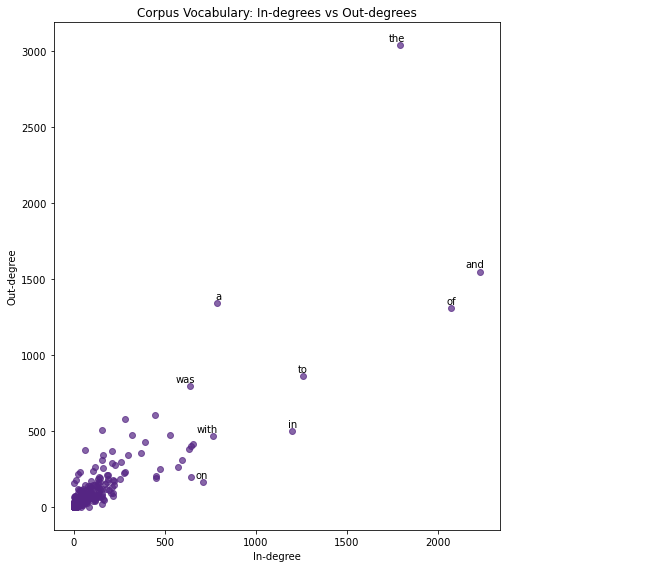

Corpus Vocabulary: Term Frequency vs In-degrees
Predicted intercept: 1.013205911485711
Predicted slope: 0.7889933885237841


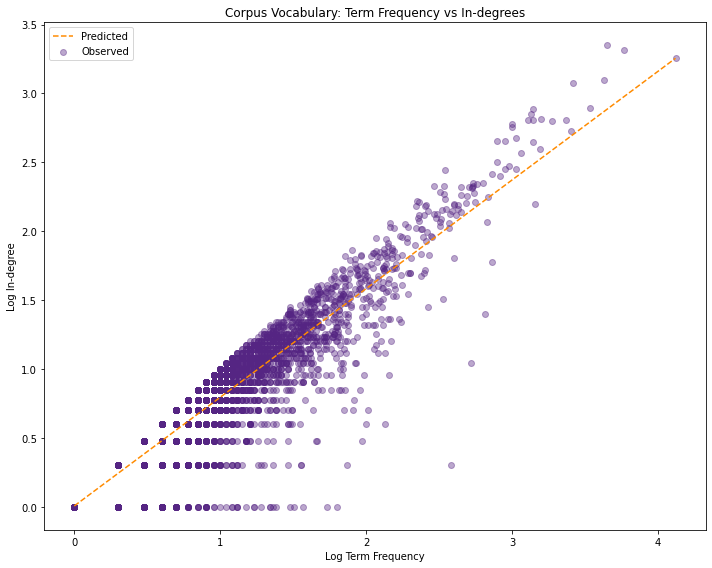

Corpus Vocabulary: Term Frequency vs Out-degrees
Predicted intercept: 1.009511890877886
Predicted slope: 0.8312705768100931


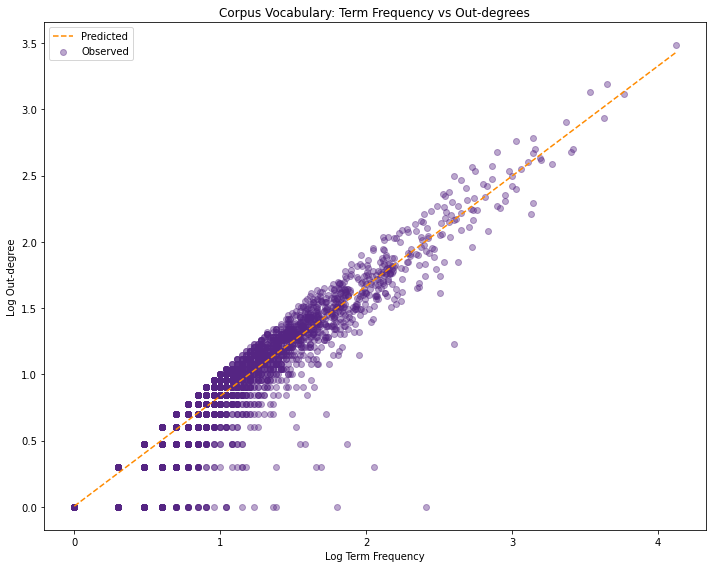

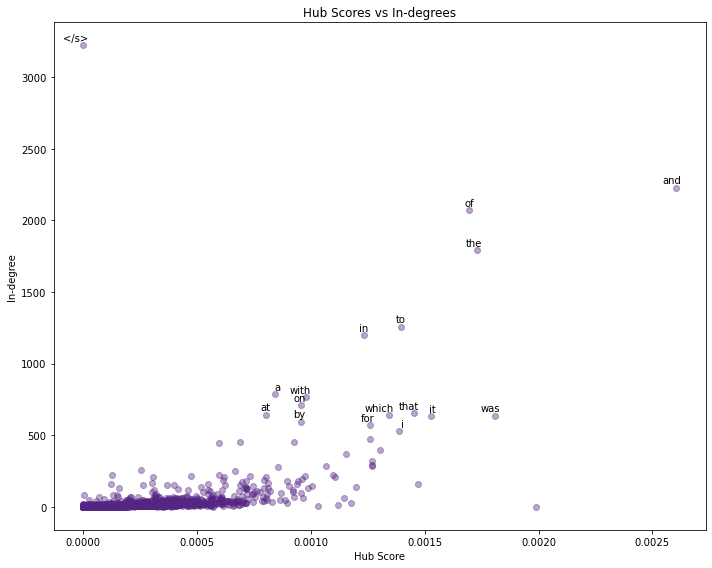

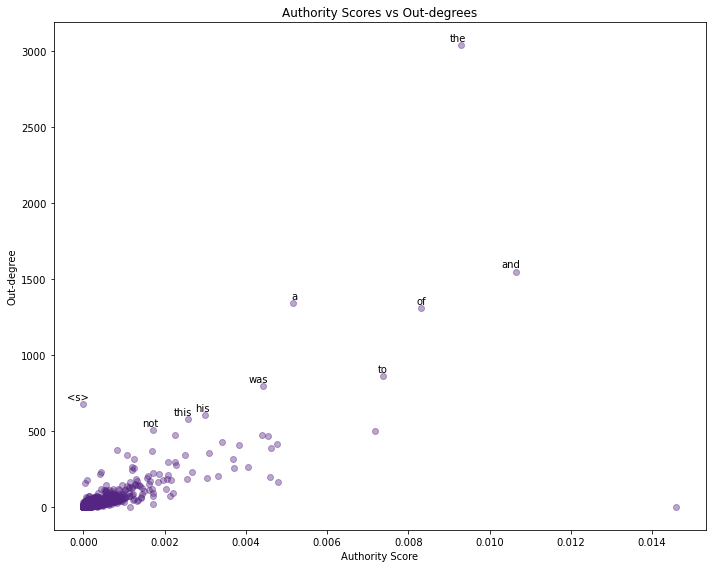

In [9]:
plots_base(vocab_G, 'Corpus Vocabulary')

### Embeddings Similarity vs Network Distance

The network is scale-free, hence avg. path length is ln ln N

In [10]:
np.log(np.log(len(vocab_G)))

2.235878935961883

In [11]:
def load_word2vec(filepath) -> Word2Vec:
    """Load Word2Vec embeddings
    Parameters:
        filepath (str): the location to load embeddings from
    Returns:
        Word2Vec: word embeddings"""
    
    model = Word2Vec.load(filepath)
    
    print('Vocab size |V|:', len(model.wv.index_to_key))
    
    return model

In [12]:
ttl_sg = load_word2vec('./Word2Vec/ttl_200_1.model')
atw_sg = load_word2vec('./Word2Vec/atw_200_1.model')

Vocab size |V|: 8669
Vocab size |V|: 6829


In [13]:
def shortest_path(G: nx.DiGraph, source, target) -> float:
    """Get the shortest path between two nodes of a graph
    Parameters:
        G (nx.DiGraph): the network
        source (str): the source node
        target (str): the target node
    Returns:
        float: the path length, infinity if no path"""
    
    if (source, target) in G.out_edges(source) or (target, source) in G.in_edges(source):
        return 1
    
    try:
        return min(len(nx.bidirectional_shortest_path(G, source, target)) - 1, len(nx.bidirectional_shortest_path(G, target, source)) - 1)
    except:
        return float('inf')

In [14]:
def get_n_most_similar(model, token, n = 20) -> list:
    """Get the n most similar words of a token
    Parameters:
        model (Word2Vec): word embeddings model
        token (str): the target
        n (int): the max number of similar words to find (default: 20)
    Returns:
        dict: a list of similar words with the token appended at the end"""
    
    if token in model.wv:
        words = {w: sim for w, sim in model.wv.most_similar(token, topn = n) if w not in [SENT_BEG, SENT_END]}
        
        return words
    
    return dict()

In [15]:
def similarity_v_path(G: nx.DiGraph, model, token, n = 20) -> (dict, dict):
    """Calculate avg. vector similarity and avg. shortest path length for a word
    Parameters:
        G (nx.DiGraph): the network
        model (Word2Vec): word embeddings model
        token (str): the word
        n (int): number of words (default: 20)"""
    
    similar_words = get_n_most_similar(model, token, n)
    
    path_lens = {i: shortest_path(G, token, i) for i in similar_words}
    
    print(np.mean(list(similar_words.values())), np.mean(list(path_lens.values())))
    
    return similar_words, path_lens

In [16]:
sim, pl = similarity_v_path(vocab_G, atw_sg, 'fogg')

0.8447337527024118 1.263157894736842


In [17]:
sim, pl = similarity_v_path(vocab_G, atw_sg, 'aouda')

0.9593060204857274 1.6842105263157894


In [18]:
sim, pl = similarity_v_path(vocab_G, ttl_sg, 'nemo')

0.839078676700592 1.6


In [19]:
sim, pl = similarity_v_path(vocab_G, ttl_sg, 'aronnax')

0.9706825286149978 1.75
